In [220]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'asl-signs:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F46105%2F5087314%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240423%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240423T005456Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D05de445137be291fccc16e31846b960ae442369be6b9cf76c85d5982dc27fd1c5dc4f9cfd2ded022a600781a52b00cfee68e542bb41dfda85082af356e8d746d5841f6d5f759649c931aebe0935a25026cdc36fd4352c8e285ff10ebca3f422b5928426de9bccd0205651e6553eb9c19caab051ff92390653248efe87c53bd4d13047dddce5e7e904c60b047de829dd928ea3b7008ac7bf5453ec669f5808d85d12eb32f86a61b4ee98b056fcb8ff80bdae6039103aa2fef7289547b942d309dd9e1f14c346a0d8700e6f7988911a44dbc63ea1c8a3a52d12ef8835f3946e6732bab3c4e861835a15178d6886cabbbdcf45222311e8fe7a50bb41ffb832b29ba'

KAGGLE_INPUT_PATH='kaggle/input'
KAGGLE_WORKING_PATH='kaggle/working'
KAGGLE_SYMLINK='kaggle'

'''
Uncomment these lines to download the data from Kaggle. If already downloaded, commemt these lines.
'''

# os.makedirs(KAGGLE_SYMLINK)
# os.makedirs(KAGGLE_INPUT_PATH, 0o777)
# os.makedirs(KAGGLE_WORKING_PATH, 0o777)

# for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
#     directory, download_url_encoded = data_source_mapping.split(':')
#     download_url = unquote(download_url_encoded)
#     filename = urlparse(download_url).path
#     destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
#     try:
#         with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
#             total_length = fileres.headers['content-length']
#             print(f'Downloading {directory}, {total_length} bytes compressed')
#             dl = 0
#             data = fileres.read(CHUNK_SIZE)
#             while len(data) > 0:
#                 dl += len(data)
#                 tfile.write(data)
#                 done = int(50 * dl / int(total_length))
#                 sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
#                 sys.stdout.flush()
#                 data = fileres.read(CHUNK_SIZE)
#             if filename.endswith('.zip'):
#               with ZipFile(tfile) as zfile:
#                 zfile.extractall(destination_path)
#             else:
#               with tarfile.open(tfile.name) as tarfile:
#                 tarfile.extractall(destination_path)
#             print(f'\nDownloaded and uncompressed: {directory}')
#     except HTTPError as e:
#         print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
#         continue
#     except OSError as e:
#         print(f'Failed to load {download_url} to path {destination_path}')
#         continue

# print('Data source import complete.')


'\nUncomment these lines to download the data from Kaggle. If already downloaded, commemt these lines.\n'

In [221]:
from glob import glob
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import OneHotEncoder

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [222]:
NUM_FRAMES=60

In [223]:
data_files = glob("kaggle/input/asl-signs/train_landmark_files/*/*.parquet", recursive=True)


In [225]:
example_pq_df = pd.read_parquet(data_files)
first_frame_df = example_pq_df[example_pq_df['frame'] == example_pq_df['frame'].iloc[0]]
first_frame_head_df = first_frame_df[first_frame_df['type'] == 'face']
first_frame_pose_df = first_frame_df[first_frame_df['type'] == 'pose']
first_frame_left_hand_df = first_frame_df[first_frame_df['type'] == 'left_hand']
first_frame_right_hand_df = first_frame_df[first_frame_df['type'] == 'right_hand']

print(example_pq_df.head())
print("landmarks per frame", len(first_frame_df))
print("face landmarks ", len(first_frame_head_df))
print("pose landmarks ", len(first_frame_pose_df))
print("left hand landmarks ", len(first_frame_left_hand_df))
print("right hand landmarks ", len(first_frame_right_hand_df))


train_entries = [file.split('/')[5].split('.')[0] for file in data_files]
print("Number of entries: ", len(train_entries))



KeyError: 'kaggle/input/asl-signs/train_landmark_files/4718/1187990396.parquet'

In [230]:
'''
Methods to either upsample or downsample frames to return NUM_FRAMES freams
'''

def interpolate_frames(pq_df, num_frames=NUM_FRAMES):
    '''
    Upsample frames to return NUM_FRAMES frames. Do this by sampling frames at even intervels and copying them

    Parameters:
    pq_df: pandas dataframe containing landmarks
    num_frames: number of frames to return

    Returns:
    new_df: pandas dataframe with NUM_FRAMES frames
    '''
    current_frames = pq_df['frame'].unique()
    start_frame = current_frames[0] 
    needed_frames = num_frames - len(current_frames)
    frame_interval = len(current_frames) // (needed_frames + 1)
    for i in range(1, needed_frames + 1):
        frame = start_frame + i * frame_interval % len(pq_df['frame'].unique())
        end_index_of_first_half = len(pq_df[pq_df['frame'] <= frame])
        pq_df = pd.concat([pq_df[pq_df['frame'] <= frame], pq_df[pq_df['frame'] >= frame]], )
        pq_df = pq_df.reset_index(drop=True)
        pq_df.loc[pq_df.index >= end_index_of_first_half, 'frame'] = pq_df.loc[pq_df.index >= end_index_of_first_half, 'frame'] + 1
    for index, frame in enumerate(pq_df['frame'].unique()):
        pq_df.loc[pq_df['frame'] == frame, 'frame'] = index
    return pq_df

def extract_frames(pq_df, method='uniform' , num_frames=NUM_FRAMES):  
    '''
    Method to handle files with more than num_frames frames. Three different methods to sample num_frames frames:
    1. uniform: sample frames uniformly from the entire video   
    2. end: sample the last num_frames frames
    3. start: sample the first num_frames frames

    I think end my work best

    Parameters:
    pq_df: pandas dataframe containing landmarks
    method: method to sample frames
    num_frames: number of frames to return

    Returns:
    new_df: pandas dataframe with num_frames frames
    '''
    if method == 'uniform':
        total_frames = len(pq_df['frame'].unique())
        first_frame = pq_df['frame'].iloc[0]
        step_size = total_frames // num_frames
        frame_indices_range = range(first_frame, total_frames+first_frame, step_size)
    elif method == 'end':
        unique_frames = pq_df['frame'].unique()
        frame_indices_range = unique_frames[-num_frames:]
    elif method == 'start':
        unique_frames = pq_df['frame'].unique()
        frame_indices_range = unique_frames[:num_frames]
    frame_indices = list(frame_indices_range)[-num_frames:]
    new_df = pq_df[pq_df['frame'].isin(frame_indices)].copy()
    for index, frame in enumerate(frame_indices):
        new_df.loc[new_df['frame'] == frame, 'frame'] = index
    return new_df

interpolate_frames_df = interpolate_frames(pd.read_parquet(data_files[4]))
print(interpolate_frames_df.frame.unique())
interpolate_frames_df.head()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]


,frame,row_id,type,landmark_index,x,y,z
0,0,9-face-0,face,0,0.566535,0.485979,-0.048370
1,0,9-face-1,face,1,0.570756,0.438695,-0.068397
2,0,9-face-2,face,2,0.568516,0.453796,-0.041725
3,0,9-face-3,face,3,0.557075,0.410244,-0.044175
4,0,9-face-4,face,4,0.570628,0.428170,-0.070086


In [227]:
def onehot_encode(data, num_classes):
    '''
    one hot encode the labels

    Parameters:
    data: list of labels
    num_classes: number of classes in the dataset

    Returns:
    one hot encoded labels
    '''
    num_labels = num_classes
    one_hot = np.zeros((len(data), num_labels), dtype=int)
    one_hot[np.arange(len(data)), data] = 1
    return one_hot

def labels_mapping(csv_file, key_column, value_column):
    '''
    retrieve labels mapping from csv file. Create a labels dictionary mapping each key to a value 

    Parameters:
    csv_file: path to csv file
    key_column: column containing the keys
    value_column: column containing the values

    Returns:
    dictionary mapping keys to values
    '''
    df = pd.read_csv(csv_file)
    df[key_column] = df[key_column].astype(str)
    dictionary = df.set_index(key_column)[value_column].to_dict()
    return dictionary

def sample_parquets(data_file, n=10000):
    '''
    I added this method to sample the data for training. This is because the data is too large to fit in memory.
    To use all data, set n to the length of the data_file.

    Parameters:
    data_file: list of paths to parquet files
    n: number of samples to return

    Returns:
    data: list of sampled data dfs 
    '''
    indices = np.random.choice(len(data_file), n)
    labels_mapping_dict = labels_mapping('kaggle/input/asl-signs/train.csv', 'sequence_id', 'sign')
    data = [data_file[i] for i in indices]
    labels = [labels_mapping_dict[d.split('/')[-1].split('.')[0]] for d in data]
    label_indexes = convert_labels_to_indexes(labels)
    one_hot_labels = onehot_encode(label_indexes, 250)
    return data, one_hot_labels

def convert_labels_to_indexes(labels):
    '''
    map each sign to an index. This is useful for training the model

    Parameters:
    labels: list of labels

    Returns:
    list of indexes corresponding to the labels
    '''
    json.load(open('kaggle/input/asl-signs/sign_to_prediction_index_map.json'))
    return [json.load(open('kaggle/input/asl-signs/sign_to_prediction_index_map.json'))[label] for label in labels]



In [250]:
def process_data(data_files):
    '''
    ensure that all entries have NUMBER_FRAMES frames

    Parameters:
    data_files: list of data file strings to process

    Returns:
    df_lists: list of dataframes with NUMBER_FRAMES frames
    '''
    df_lists = []
    for i, data  in enumerate(data_files):
        data_df = pd.read_parquet(data)
        data_df = data_df[data_df['type'].isin(['left_hand', 'right_hand'])]
        new_df = None
        if(i % 100 == 0):
            print(i)
        if len(data_df['frame'].unique()) < NUM_FRAMES:
            new_df = interpolate_frames(data_df)
        elif len(data_df['frame'].unique() > NUM_FRAMES):
            new_df = extract_frames(data_df, method='end')
        df_lists.append(new_df)
    return df_lists
      
            
            


In [267]:
X_train, y_train = sample_parquets(data_files, 1000)
X_train = process_data(X_train)

0
100
200
300
400
500
600
700
800
900


In [268]:
def mask_nan_hand(df_list):
    '''
    This dataset consists of one handed signs. Mask the hand that has more nan values

    Parameters:
    df_list: list of dataframes

    Returns:
    new_df: list of dataframes with the hand with more nan values removed
    '''
    new_df = []
    for df in df_list:
        left_hand_landmarks = df[df['type'] == 'left_hand'] 
        right_hand_landmarks = df[df['type'] == 'right_hand']
        count_left_hand_nan = left_hand_landmarks.isna().sum().sum()
        count_right_hand_nan = right_hand_landmarks.isna().sum().sum()
        if count_left_hand_nan > count_right_hand_nan:
            df = df[df['type'] == 'right_hand']
        else:
            df = df[df['type'] == 'left_hand']
        new_df.append(df)
        
    return new_df
            
X_train = mask_nan_hand(X_train)


In [269]:
for x in X_train:
    if len(x)!= 1260:
        print("Length of x is not 1260", len(x))
    if len(x['frame'].unique()) != NUM_FRAMES:
        print("Number of frames is not 60", len(x['frame'].unique()))

print("Length of X_train", len(X_train))
print("Length of y_train", len(y_train))

Length of X_train 1000
Length of y_train 1000


In [270]:
def replace_nan(df, val=0.0000001):
    '''
    Replace any nan values with val

    Parameters:
    df: dataframe
    val: value to replace nan values with
    
    Returns:
    numpy array of the dataframe with nan values replaced with val
    '''
    return np.asarray(df[['x', 'y']].fillna(val).values)

def normalize_coords(coords):
    '''set the mean of the data to 0 and std dev to 1'''
    mean = np.mean(coords, axis=0)
    std_dev = np.std(coords, axis=0)
    return (coords - mean) / std_dev


X_train = [normalize_coords(replace_nan(x)) for x in X_train]
X_train = np.array(X_train)

In [274]:
class NN_model(torch.nn.Module):
    def __init__(self, input_dims, output_classes=250):
        super(NN_model, self).__init__()
        self.linear1 = nn.Linear(input_dims, 512)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(512, output_classes)
        
    def forward(self, x):
        x = self.linear1(x)
        x= self.activation1(x)
        x = self.linear2(x)

        return x

model = NN_model(len(X_train[0]) * 2, len(y_train[1]))
model = model.to(device)


250

Epoch 0 Loss 5.5399457067251205 Accuracy 0.013671875
Epoch 1 Loss 4.997462049126625 Accuracy 0.1435546875
Epoch 2 Loss 4.582479149103165 Accuracy 0.2080078125
Epoch 3 Loss 4.1795512437820435 Accuracy 0.259765625
Epoch 4 Loss 3.7973612025380135 Accuracy 0.3173828125
Epoch 5 Loss 3.439193105325103 Accuracy 0.3896484375
Epoch 6 Loss 3.1046242490410805 Accuracy 0.44921875
Epoch 7 Loss 2.7935254452750087 Accuracy 0.52734375
Epoch 8 Loss 2.5061438838019967 Accuracy 0.5830078125
Epoch 9 Loss 2.244445638731122 Accuracy 0.65234375
Epoch 10 Loss 2.0098143042996526 Accuracy 0.6982421875
Epoch 11 Loss 1.8015744583681226 Accuracy 0.73828125
Epoch 12 Loss 1.6191114820539951 Accuracy 0.7724609375
Epoch 13 Loss 1.4608581503853202 Accuracy 0.79296875
Epoch 14 Loss 1.3240151056088507 Accuracy 0.814453125
Epoch 15 Loss 1.2061217911541462 Accuracy 0.8349609375
Epoch 16 Loss 1.1039768606424332 Accuracy 0.8486328125
Epoch 17 Loss 1.0159778706729412 Accuracy 0.8623046875
Epoch 18 Loss 0.9396761520765722 Accu

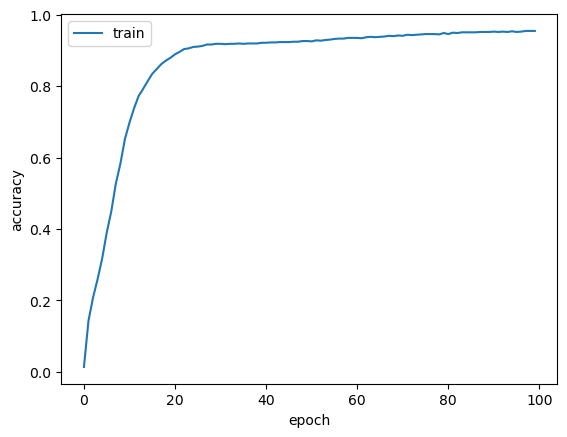

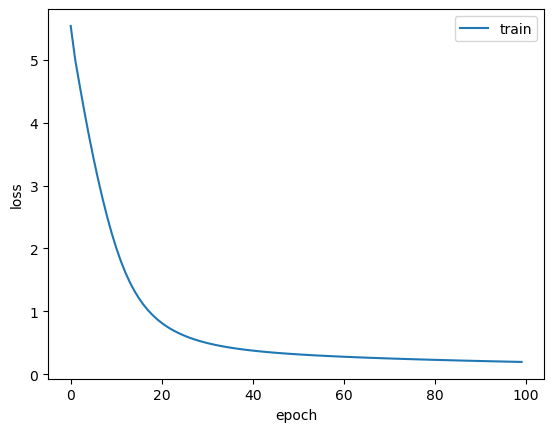

In [272]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
                       
def train_model(model, X_train, y_train, criterion, optimizer, epochs, batch_size):
    loss_list = []
    train_acc_list = []
    for epoch in range(epochs):
        epoch_loss = []
        epoch_train_acc = []
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size, :]
            X_batch = torch.tensor(X_batch, dtype=torch.float32).to(device)
            y_batch = torch.tensor(y_batch, dtype=torch.float32).to(device)
            X_batch = X_batch.view(X_batch.shape[0], -1, X_batch.shape[1] * X_batch.shape[2])
            optimizer.zero_grad()

            output = model(X_batch).squeeze()
            y_pred_train = torch.argmax(output, dim=1)
            y_actual_labels = torch.argmax(y_batch, dim=1)
            train_acc = (y_pred_train == y_actual_labels).float().mean()
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            epoch_loss.append(loss.item())
            epoch_train_acc.append(train_acc)
        loss_list.append(sum(epoch_loss) / len(epoch_loss))
        train_acc_list.append(sum(epoch_train_acc) / len(epoch_train_acc))
        print(f'Epoch {epoch} Loss {loss_list[-1]} Accuracy {train_acc_list[-1]}')
    return model, loss_list, train_acc_list

model, loss, train_acc = train_model(model, X_train, y_train, criterion, optimizer, 100, 32)

plt.figure()
plt.plot(train_acc)
plt.legend(['train'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig('train_acc.png')

plt.figure()
plt.plot(loss)
plt.legend(['train'], loc='upper right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig('train_loss.png')
